In [18]:
pip install seaborn 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    mean_squared_error, r2_score
)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings("ignore")


In [20]:
df = pd.read_csv("customer_churn_ml.csv")
df.head()


,customer_id,age,gender,tenure_months,monthly_charges,total_charges,contract_type,payment_method,internet_service,support_tickets,churn,lifetime_value
0,1,45,Male,12,70.5,846,Month-to-month,Credit Card,Fiber,3,1,1200
1,2,34,Female,48,55.2,2649,Two year,Bank Transfer,DSL,0,0,6800
2,3,29,Female,5,89.1,445,Month-to-month,Electronic Check,Fiber,5,1,900
3,4,62,Male,72,40.3,2901,Two year,Credit Card,NaN,1,0,8200
4,5,51,Female,24,65.0,1560,One year,Debit Card,DSL,2,0,4100


In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       200 non-null    int64  
 1   age               200 non-null    int64  
 2   gender            200 non-null    object 
 3   tenure_months     200 non-null    int64  
 4   monthly_charges   200 non-null    float64
 5   total_charges     200 non-null    int64  
 6   contract_type     200 non-null    object 
 7   payment_method    200 non-null    object 
 8   internet_service  144 non-null    object 
 9   support_tickets   200 non-null    int64  
 10  churn             200 non-null    int64  
 11  lifetime_value    200 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 18.9+ KB


In [22]:
df.describe()


,customer_id,age,tenure_months,monthly_charges,total_charges,support_tickets,churn,lifetime_value
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,44.325000,32.475000,67.389000,1687.645000,2.340000,0.385000,4333.600000
std,57.879185,11.957184,25.591876,20.507392,982.520724,2.079911,0.487816,2875.820711
min,1.000000,24.000000,1.000000,38.600000,98.000000,0.000000,0.000000,500.000000
25%,50.750000,34.000000,10.000000,45.050000,761.750000,1.000000,0.000000,1350.000000
50%,100.500000,44.000000,25.000000,67.350000,1692.000000,2.000000,0.000000,4325.000000
75%,150.250000,55.000000,60.000000,85.425000,2688.000000,4.000000,1.000000,7525.000000
max,200.000000,65.000000,75.000000,100.200000,3522.000000,6.000000,1.000000,8450.000000


In [23]:
df.isnull().sum()


customer_id          0
age                  0
gender               0
tenure_months        0
monthly_charges      0
total_charges        0
contract_type        0
payment_method       0
internet_service    56
support_tickets      0
churn                0
lifetime_value       0
dtype: int64

In [24]:
# Create new features
df["avg_monthly_spend"] = df["total_charges"] / (df["tenure_months"] + 1)
df["tickets_per_month"] = df["support_tickets"] / (df["tenure_months"] + 1)


In [25]:
X = df.drop(["customer_id", "churn", "lifetime_value"], axis=1)
y_class = df["churn"]
y_reg = df["lifetime_value"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

models_class = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(eval_metric="logloss")
}

results = {}

for name, model in models_class.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds)
    }

pd.DataFrame(results).T


,Accuracy,F1
Logistic Regression,1.0,1.0
Random Forest,1.0,1.0
XGBoost,1.0,1.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200),
    "XGBoost": XGBRegressor()
}

reg_results = {}

for name, model in models_reg.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    reg_results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }

pd.DataFrame(reg_results).T


,RMSE,R2
Linear Regression,102.380613,0.998767
Random Forest,95.325880,0.998931
XGBoost,134.751413,0.997865


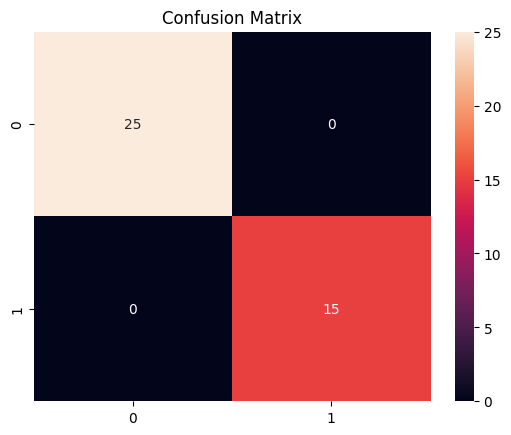

In [28]:
best_model = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200))
])

best_model.fit(X_train, y_class.loc[X_train.index])
preds = best_model.predict(X_test)

cm = confusion_matrix(y_class.loc[X_test.index], preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


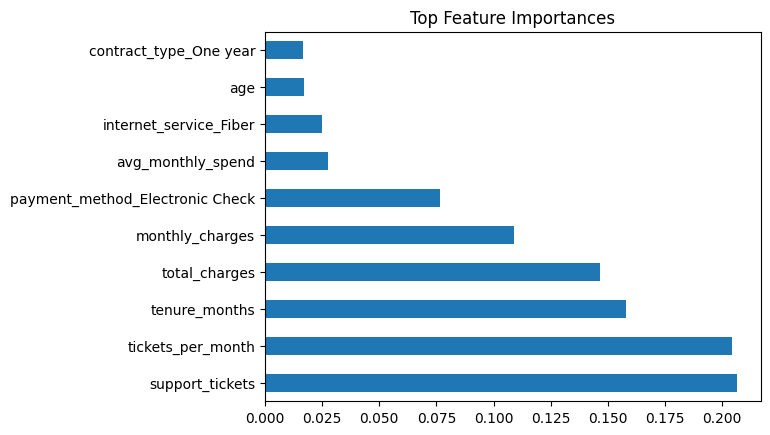

In [29]:
feature_names = (
    num_features.tolist() +
    list(best_model.named_steps["prep"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features))
)

importances = best_model.named_steps["model"].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
fi.plot(kind="barh")
plt.title("Top Feature Importances")
plt.show()


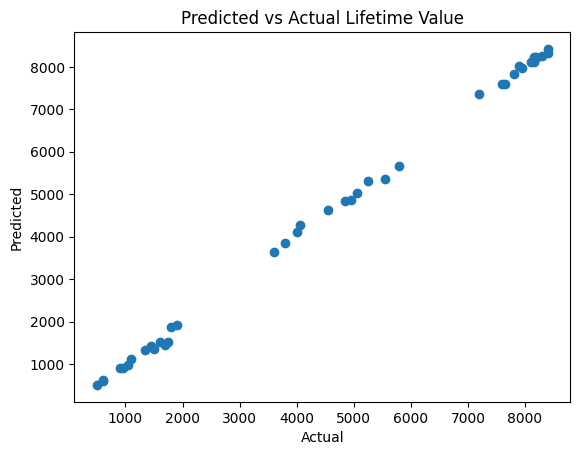

In [30]:
best_reg = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200))
])

best_reg.fit(X_train, y_train)
preds = best_reg.predict(X_test)

plt.scatter(y_test, preds)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Lifetime Value")
plt.show()
